In [1]:
import pandas as pd
from tensorflow import Module
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score,precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("undersampled_spam.csv", encoding="latin")
df = df.dropna()
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,type,sms,processedSMS,filteredSMS
630,0,Talk to g and x about that,talk g x,"['talk', 'g', 'x']"
759,1,"As a valued customer, I am pleased to advise y...",valu custom pleas advis follow recent review m...,"['valu', 'custom', 'pleas', 'advis', 'follow',..."
644,0,"Cool, what time you think you can get here?",cool time think get,"['cool', 'time', 'think', 'get']"
797,1,Fancy a shag? I do.Interested? sextextuk.com t...,fanci shag interest sextextuk com txt xxuk suz...,"['fanci', 'shag', 'interest', 'sextextuk', 'co..."
419,0,Very hurting n meaningful lines ever: \I compr...,hurt n meaning line ever compromis everyth love,"['hurt', 'n', 'meaning', 'line', 'ever', 'comp..."


In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.processedSMS)
vocabCount = len(tokenizer.word_index)+1
vocabCount

3870

In [4]:
tokenized_sms = tokenizer.texts_to_sequences(df.processedSMS.to_list())
max_length = max([len(sms) for sms in tokenized_sms])
max_length

66

In [5]:
paddedSMS = pad_sequences(tokenizer.texts_to_sequences(df.processedSMS.to_list()), padding="pre", maxlen=max_length)

In [6]:
# Splitting Data
features, labels = paddedSMS , df["type"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=2022, stratify=labels)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=2022, stratify=y_test)

In [7]:
class SMSClassifier(Module):
    def __init__(self, dictionary_len=vocabCount, embedding_dim=64):
        super(SMSClassifier, self).__init__()
        self.model = Sequential([
            Embedding(input_dim=dictionary_len, output_dim=embedding_dim),
            Bidirectional(LSTM(units=embedding_dim)),
            Dropout(0.5),
            Dense(units=1, activation="sigmoid")
            ])
        self.model.compile(optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"], loss="binary_crossentropy")

    def train(self, train_features, train_labels, valid_features, valid_labels, epochs):
        progress = self.model.fit(train_features, train_labels, validation_data=(valid_features, valid_labels), epochs=epochs)
        self.save()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), dpi=150)
        ax[0].set_title("Training Loss (green) vs Validation Loss (blue)")
        ax[0].plot(progress.history["loss"], "g")
        ax[0].plot(progress.history["val_loss"], "b")
        ax[1].set_title("Training Accuracy (green) vs Validation Accuracy (blue)")
        ax[1].plot(progress.history["accuracy"], "g")
        ax[1].plot(progress.history["val_accuracy"], "b")

    def evaluate(self, y_features, y_true, qualifier=0.5):
        y_pred = [(prediction[0] > qualifier).astype(int) for prediction in self.model.predict(y_features)]
        print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
        print(f"Precision: {precision_score(y_true, y_pred, zero_division=0)}")
        print(f"Recall: {recall_score(y_true, y_pred, zero_division=0)}")
        rc1, rc2, rc3 = precision_recall_curve(y_true, y_pred)
        print(f"PR_AUC: {auc(rc2,  rc1)}")
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0, 1]).plot()
        plt.axis("off")
        plt.show()

    def save(self, path="smsclassifier.h5"):
        self.model.save(path)

    def load(self, path="smsclassifier.h5"):
        self.model.load_weights(path)

Epoch 1/100
33/33 [==============================] - 6s 73ms/step - loss: 0.6912 - accuracy: 0.5589 - val_loss: 0.6886 - val_accuracy: 0.5580
Epoch 2/100
33/33 [==============================] - 2s 50ms/step - loss: 0.6844 - accuracy: 0.6440 - val_loss: 0.6787 - val_accuracy: 0.7455
Epoch 3/100
33/33 [==============================] - 2s 49ms/step - loss: 0.6606 - accuracy: 0.6928 - val_loss: 0.6372 - val_accuracy: 0.5134
Epoch 4/100
33/33 [==============================] - 2s 48ms/step - loss: 0.6079 - accuracy: 0.6124 - val_loss: 0.5795 - val_accuracy: 0.7768
Epoch 5/100
33/33 [==============================] - 2s 48ms/step - loss: 0.5262 - accuracy: 0.8230 - val_loss: 0.4940 - val_accuracy: 0.8438
Epoch 6/100
33/33 [==============================] - 2s 49ms/step - loss: 0.4237 - accuracy: 0.8574 - val_loss: 0.4305 - val_accuracy: 0.8259
Epoch 7/100
33/33 [==============================] - 2s 48ms/step - loss: 0.3764 - accuracy: 0.8737 - val_loss: 0.3892 - val_accuracy: 0.8438
Epoch 

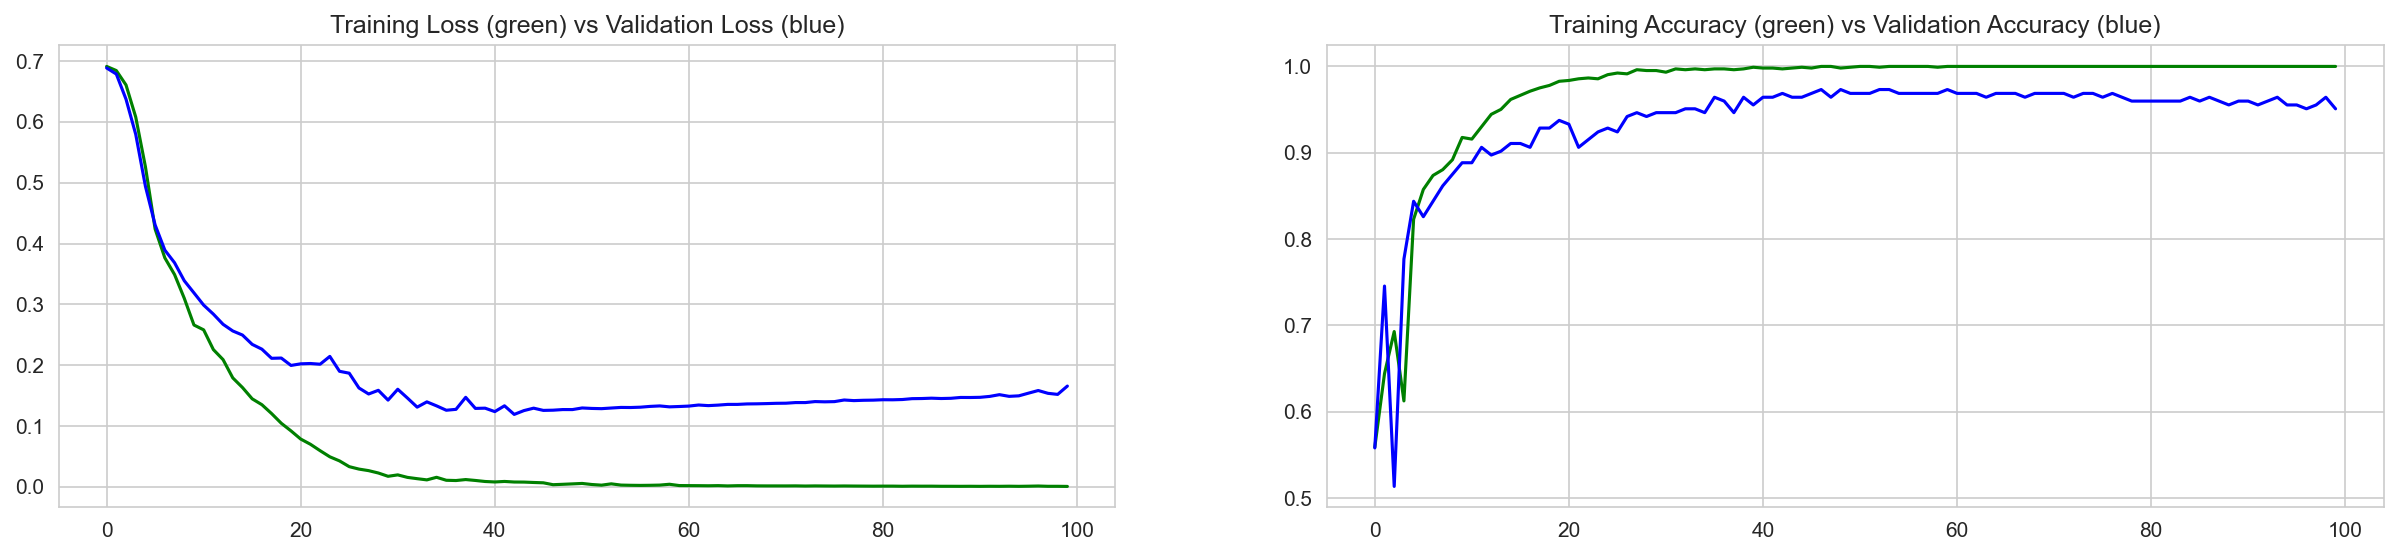

In [8]:
model = SMSClassifier()
model.train(x_train, y_train, x_val, y_val, epochs=100)

In [9]:
model.load()

33/33 [==============================] - 1s 15ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
PR_AUC: 1.0


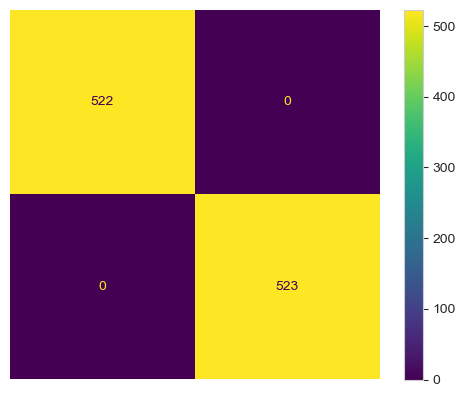

In [10]:
model.evaluate(x_train, y_train)

7/7 [==============================] - 0s 15ms/step
Accuracy: 0.9508928571428571
Precision: 0.963302752293578
Recall: 0.9375
PR_AUC: 0.966026376146789


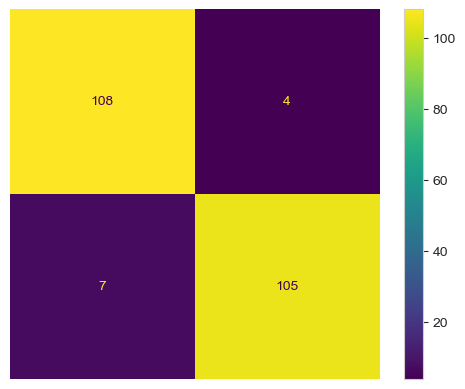

In [11]:
model.evaluate(x_val, y_val)

7/7 [==============================] - 0s 15ms/step
Accuracy: 0.9910714285714286
Precision: 0.9910714285714286
Recall: 0.9910714285714286
PR_AUC: 0.9933035714285714


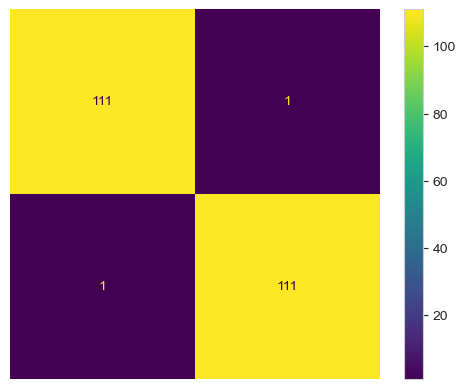

In [12]:
model.evaluate(x_test, y_test)